In [261]:
%pylab inline
import multiprocessing as mp
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [232]:
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.8,5201)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = ['H','He','C','N','O','Ne','Mg','Si','Fe']

# Producing the SSP birth elemental fractions (here we use solar)
solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

In [247]:
# yieldset default
a.yield_table_name_sn2 = 'TNG_net'#'chieffi04_net'#'TNG_net'
a.yield_table_name_agb = 'TNG_net'#'Karakas16_net'#Ventura_net'#'TNG_net'
a.yield_table_name_1a = 'TNG'#'Seitenzahl'#'TNG'

# imf parameters
a.only_net_yields_in_process_tables = True
a.imf_type_name = 'Chabrier_TNG'
#default
a.high_mass_slope = -2.3
a.imf_parameter = (0.852464,0.237912,0.079,0.69, a.high_mass_slope)
a.mmin = 0.1
a.mmax = 100
# 100,000,000 mass steps are smooth enough for 1000 time steps
a.mass_steps = 200000 #2000 # 200000
a.sn2mmin = 8.
a.sn2mmax = 100.
a.bhmmin = float(a.sn2mmax) ## maximum of hypernova
a.bhmmax = float(a.mmax) ## maximum of the IMF

# sn1a delay parameters for maoz
#default
a.N_0 = 0.0012882#np.power(10,-2.89)
a.sn1a_time_delay = 0.04#np.power(10,-0.8)
#alternative
#a.N_0 = np.power(10,-3.49)
#a.sn1a_time_delay = np.power(10,-0.88)

a.sn1a_exponent = 1.12
a.dummy = 0.0
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

In [248]:
from Chempy.wrapper import SSP_wrap

basic_ssp = SSP_wrap(a)

In [249]:
basic_ssp.calculate_feedback(0.02,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

In [250]:
differential_table = True # True is the default Chempy behaviour

x = basic_ssp.agb_table
y = basic_ssp.sn1a_table
z = basic_ssp.sn2_table
s = basic_ssp.bh_table
d = basic_ssp.table

#x2 = x+ (d['mass_of_ms_stars_dying']-x['mass_in_remnants'])

u = np.zeros_like(x)
names = list(u.dtype.names)

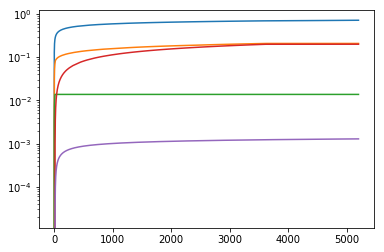

In [251]:
plt.plot(np.cumsum(d['mass_of_ms_stars_dying']))
plt.plot(np.cumsum(d['mass_in_remnants']))
plt.plot(np.cumsum(d['sn2']))
plt.plot(np.cumsum(d['pn']))
plt.plot(np.cumsum(d['sn1a']))
plt.yscale('log')

In [252]:
ejected_mass = d['mass_of_ms_stars_dying']-d['mass_in_remnants']

d2 = np.copy(d)
for e,el in enumerate(elements_to_trace):
    d2[el] = d[el]+ejected_mass*solar_fractions[e]

In [253]:
final_els=[]
for el in elements_to_trace:
    final_els.append(np.sum(d2[el]))

In [254]:
for j,jtem in enumerate(names):
    u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
for el in elements_to_trace:
    d[el] = u[el]

In [255]:
from Chempy.weighted_yield import imf_mass_fraction_non_nativ
invimf = basic_ssp.inverse_imf
imf = basic_ssp.imf

sn2_mass=imf_mass_fraction_non_nativ(imf.dm,imf.x,a.sn2mmin,a.sn2mmax)
agb_mass = imf_mass_fraction_non_nativ(imf.dm,imf.x,a.agbmmin,a.agbmmax)
sn1a_mass = -np.sum(y['mass_in_remnants'])
sn1a_mass = np.sum(d['sn2'])*1.3743416

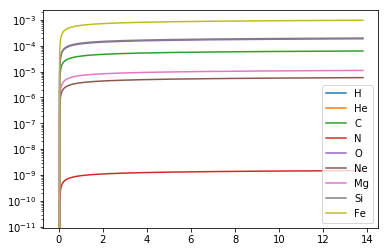

In [256]:
for el in elements_to_trace:
    plt.plot(time_steps,np.cumsum(y[el]),label=el)
plt.legend()
plt.yscale('log')

In [257]:
full_agb,full_sn2,full_sn1a = [np.zeros(len(elements_to_trace)) for _ in range(3)]
for e,el in enumerate(elements_to_trace):
        full_agb[e]=np.sum(x[el])+(agb_mass-np.sum(x['mass_in_remnants']))*solar_fractions[e]
        full_sn2[e]=np.sum(z[el])+(sn2_mass-np.sum(z['mass_in_remnants']))*solar_fractions[e]
        full_sn1a[e]=np.sum(y[el])

In [244]:
# np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/yields_plot_WrongYields.npz',
#         agb=full_agb,sn2=full_sn2,sn1a=full_sn1a,elements=elements_to_trace)

In [258]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/yields_plot_TNG.npz',
        agb=full_agb,sn2=full_sn2,sn1a=full_sn1a,elements=elements_to_trace)

In [259]:
yieldT=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/yields_plot_TNG.npz')
yieldW=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/yields_plot_WrongYields.npz')

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


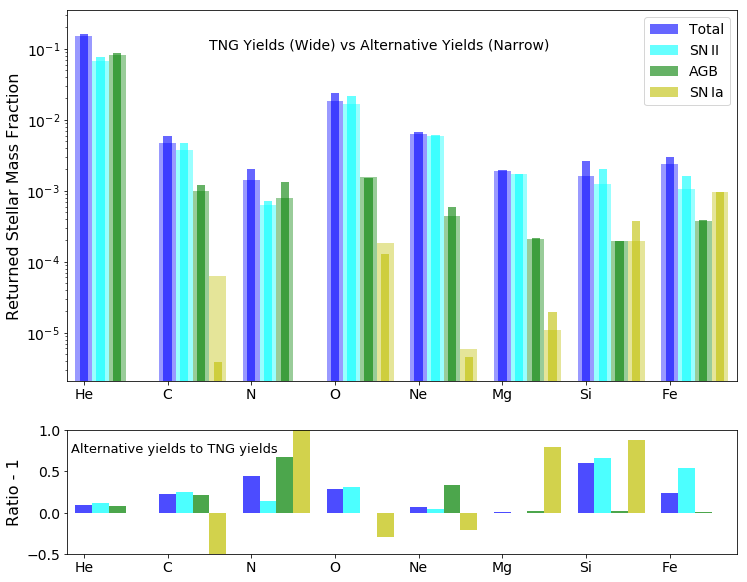

In [277]:
from matplotlib import gridspec

# plot it
fig = plt.figure(figsize=(12, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])

width=0.2
al1=0.4
yields=yieldT
xax=np.arange(len(elements_to_trace))
ax0.bar(xax,yields.f.agb+yields.f.sn2+yields.f.sn1a,width,color='blue',alpha=al1)
ax0.bar(xax+width,yields.f.sn2,width,color='cyan',alpha=al1)
ax0.bar(xax+2*width,yields.f.agb,width,color='g',alpha=al1)
ax0.bar(xax+3*width,yields.f.sn1a,width,color='y',alpha=al1)
width2=0.1
yields=yieldW
al2=0.6
ax0.bar(xax,yields.f.agb+yields.f.sn2+yields.f.sn1a,width2,color='blue',alpha=al2,label='Total')
ax0.bar(xax+width,yields.f.sn2,width2,color='cyan',alpha=al2,label=r'$\mathrm{SN\,II}$')
ax0.bar(xax+width*2.,yields.f.agb,width2,color='g',alpha=al2,label='AGB')
ax0.bar(xax+width*3.,yields.f.sn1a,width2,color='y',alpha=al2,label=r'$\mathrm{SN\,Ia}$')
ax0.bar(elements_to_trace,-full_agb)
plt.legend(fontsize=14)
ax0.set_ylim([2.1e-6,0.35])
ax0.set_xlim([0.8,8.8])
ax0.set_yscale('log');
ax0.set_ylabel('Returned Stellar Mass Fraction',fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)

ax0.text(2.5,0.1,'TNG Yields (Wide) vs Alternative Yields (Narrow)',fontsize=14)

ax1 = plt.subplot(gs[1])
width=0.2
al1=0.7
all_yield = (yieldW.f.agb+yieldW.f.sn2+yieldW.f.sn1a)/(yieldT.f.agb+yieldT.f.sn2+yieldT.f.sn1a)
agb=yieldW.f.agb/yieldT.f.agb
sn2=yieldW.f.sn2/yieldT.f.sn2
sn1a=yieldW.f.sn1a/yieldT.f.sn1a
xax=np.arange(len(elements_to_trace))
ax1.bar(xax,all_yield-1,width,color='blue',label='Total',alpha=al1)
ax1.bar(xax+width,sn2-1,width,color='cyan',label='SN\,II',alpha=al1)
ax1.bar(xax+2*width,agb-1,width,color='g',label='AGB',alpha=al1)
ax1.bar(xax+3*width,sn1a-1,width,color='y',label='SN\,Ia',alpha=al1)
ax1.plot(elements_to_trace,np.ones(len(elements_to_trace))*-10.)
ax1.set_ylim([-0.5,1])
ax1.text(.85,0.73,'Alternative yields to TNG yields',fontsize=13)
ax1.set_xlim([0.8,8.8])
ax1.set_ylabel('Ratio - 1',fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('/home/oliverphilcox/ChempyMulti/Plots2/Mass_Fraction_Comparison.pdf',bbox_inches='tight')

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


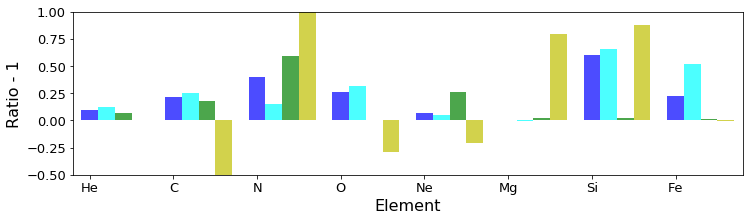

In [224]:
plt.figure(figsize=(12,3))
width=0.2
al1=0.7
all_yield = (yieldW.f.agb+yieldW.f.sn2+yieldW.f.sn1a)/(yieldT.f.agb+yieldT.f.sn2+yieldT.f.sn1a)
agb=yieldW.f.agb/yieldT.f.agb
sn2=yieldW.f.sn2/yieldT.f.sn2
sn1a=yieldW.f.sn1a/yieldT.f.sn1a
xax=np.arange(len(elements_to_trace))
plt.bar(xax,all_yield-1,width,color='blue',label='Total',alpha=al1)
plt.bar(xax+width,sn2-1,width,color='cyan',label='SN2',alpha=al1)
plt.bar(xax+2*width,agb-1,width,color='g',label='AGB',alpha=al1)
plt.bar(xax+3*width,sn1a-1,width,color='y',label='SNIa',alpha=al1)
plt.plot(elements_to_trace,np.ones(len(elements_to_trace))*-10.)
plt.ylim([-0.5,1])
plt.xlim([0.8,8.8])
plt.ylabel('Ratio - 1',fontsize=16);
plt.xlabel('Element',fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=13)

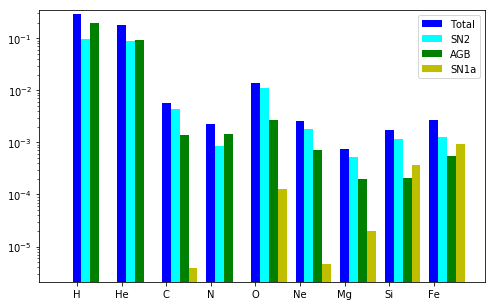

In [31]:
plt.figure(figsize=(8,5))
width=0.2
xax = np.arange(len(elements_to_trace))
plt.bar(xax,full_agb+full_sn2+full_sn1a,width,color='blue',label='Total')
plt.bar(xax+width,full_sn2,width,color='cyan',label='SN2')
plt.bar(xax+2.*width,full_agb,width,color='g',label='AGB')
plt.bar(xax+3.*width,full_sn1a,width,color='y',label='SN1a')
plt.bar(elements_to_trace,-full_agb)
plt.legend()
plt.ylim([2.1e-6,0.35])
plt.yscale('log')

In [25]:
tng_dat=[2.630e-1,7.853e-2,1.875e-1,1.213e-1,5.598e-2,6.959e-2,2.090e-3,7.948e-4,2.811e-4,4.015e-3, 2.662e-3, 1.228e-3, 1.258e-3, 5.021e-4, 7.948e-4]


In [26]:
chempy_dat = np.hstack([full_agb[0]+full_sn2[0]+full_sn1a[0],full_sn2[0],full_agb[0],
                        full_agb[1]+full_sn2[1]+full_sn1a[1],full_sn2[1],full_agb[1],
                        full_agb[-1]+full_sn2[-1]+full_sn1a[-1],full_sn2[-1],full_agb[-1],
                        full_agb[2]+full_sn2[2]+full_sn1a[2],full_sn2[2],full_agb[2],
                        full_agb[3]+full_sn2[3]+full_sn1a[3],full_sn2[3],full_agb[3],
                       ])

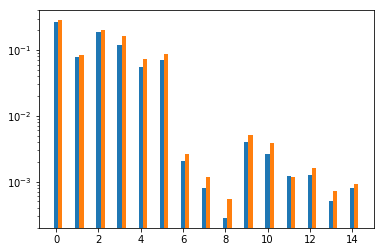

In [27]:
plt.bar(np.arange(len(tng_dat)),tng_dat,width)
plt.bar(np.arange(len(tng_dat))+width,chempy_dat,width)
plt.yscale('log')

In [28]:
print("He/H SN2: %.2f (TNG) %.2f (Chempy)"%(np.log10(tng_dat[4]/tng_dat[1]),np.log10(chempy_dat[4]/chempy_dat[1])))

He/H SN2: -0.15 (TNG) -0.07 (Chempy)


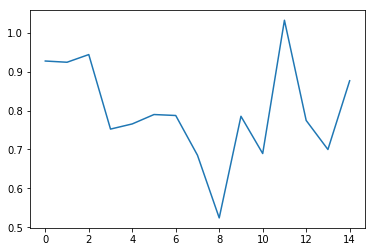

In [29]:
plt.plot(tng_dat/chempy_dat)

In [30]:
from Chempy.weighted_yield import imf_mass_fraction_non_nativ
invimf = basic_ssp.inverse_imf
imf = basic_ssp.imf
counts = np.zeros(len(invimf))
for i,item in enumerate(invimf[:-1]):
    lower = max(invimf[i+1],a.sn2mmin)
    upper = min(invimf[i],a.sn2mmax)
    print("%.1f,%.1f"%(lower,upper))
    counts[i+1]+=imf_mass_fraction_non_nativ(imf.dn,imf.x,lower,upper)
    if upper<lower and invimf[i+1]<a.sn2mmin:
        print("Broken at index %d"%i)
        break

100.0,100.0
34.2,100.0
22.8,34.2
18.1,22.8
15.4,18.1
13.7,15.4
12.4,13.7
11.5,12.4
10.7,11.5
10.1,10.7
9.6,10.1
9.1,9.6
8.7,9.1
8.4,8.7
8.1,8.4
8.0,8.1
8.0,7.9
Broken at index 16


In [31]:
invimf[:7]

array([100.        , 100.        ,  34.22518575,  22.83193262,
        18.12603262,  15.44978437,  13.68702162])

In [305]:
np.sum(counts)

0.01004147263340897

In [216]:
def imf_fun(m):
    return m**-(1-2.3)*np.exp(-(716.4/m)**0.25)

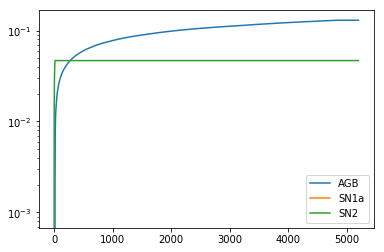

In [230]:
plt.plot(np.cumsum(x['mass_in_remnants']),label='AGB')
plt.plot(np.cumsum(y['mass_in_remnants']),label='SN1a')
plt.plot(np.cumsum(z['mass_in_remnants']),label='SN2')
plt.yscale('log');plt.legend()

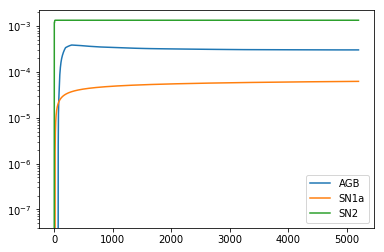

In [221]:
plt.plot(np.cumsum(x['C']),label='AGB')
plt.plot(np.cumsum(y['C']),label='SN1a')
plt.plot(np.cumsum(z['C']),label='SN2')
plt.yscale('log');plt.legend();

In [120]:
# this is solar-metallicity ejecta here
total_ejecta = d['mass_of_ms_stars_dying']-d['mass_in_remnants']

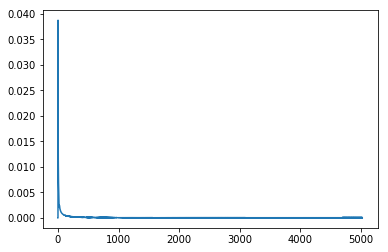

In [121]:
plt.plot(d['mass_of_ms_stars_dying']-x['mass_in_remnants'])

In [33]:
list_of_metallicities = [0.02]#np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap


def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    print(metallicity,a.yield_table_name_sn2)
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [5]:
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)

0.02 TNG_net


In [123]:
print('the data type of the SSP yield table: ',list_of_SSP_tables[2][0].dtype)
x = list_of_SSP_tables[2][0]

IndexError: list index out of range

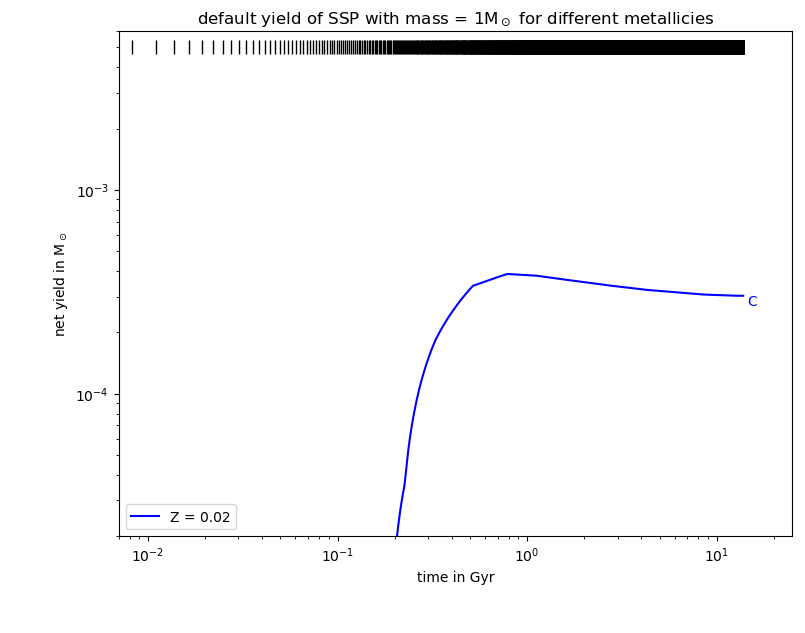

In [122]:
alpha = 0.5
factor = 1.05

## Actual plotting

fig = plt.figure(figsize=(8.69,6.69), dpi=100)
ax = fig.add_subplot(111)
ax.plot(time_steps,np.cumsum(x["Fe"]),'b', label = 'Z = 0.02')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Fe"])*0.9) ,s = 'Fe',color = 'b')

ax.plot(time_steps,np.cumsum(x["Mg"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Mg"])*0.9) ,s = 'Mg',color = 'b')

ax.plot(time_steps,np.cumsum(x["Si"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["Si"])*0.9) ,s = 'Si',color = 'b')

ax.plot(time_steps,np.cumsum(x["C"]),'b')
ax.annotate(xy = (time_steps[-1]*factor,np.sum(x["C"])*0.9) ,s = 'C',color = 'b')

ax.plot(time_steps,np.ones_like(time_steps)*5e-3,marker = '|', markersize = 10, linestyle = '', color = 'k', alpha = 2*alpha)#, label = 'time-steps')
ax.annotate(xy = (time_steps[1],2.7e-3),s = 'model time-steps', color = 'k', alpha = 2*alpha)
ax.legend(loc = 'best')

ax.set_ylim(2e-5,6e-3)
ax.set_xlim(7e-3,25)
ax.set_title(r'default yield of SSP with mass = 1M$_\odot$ for different metallicies')
ax.set_ylabel(r"net yield in M$_\odot$")
ax.set_xlabel("time in Gyr")

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [11]:
final_els=[]
for el in elements_to_trace:
    final_els.append(np.sum(x[el]))

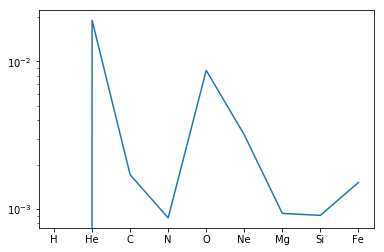

In [12]:
plt.plot(elements_to_trace,final_els)
plt.yscale('log');